In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import decimal
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from sklearn.svm import SVR

#data = pd.read_csv('data', parse_dates=[[0,1]], infer_datetime_format=True)
df = pd.read_csv("training.csv", infer_datetime_format=True,low_memory=False)

columnNames = ['int_rate','id_loan','id_borrower','loan_amt','funded_amt','funded_amt_inv',
              'term','grade','subgrade','emp_title','emp_length','home_ownership','annal_inc',
               'verification_status','issue_d','purpose','loan_cat','loan_title','zip_code',
               'state','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','mths_since_last_deliq',
               'mths_since_last_record','num_opencr_line','num_der_rec','revol_bal','revol_util',
               'total_cr_line','init_list_status']

df.columns = columnNames

# # Remove the following columns since it has too many missing values
# df = df.drop(['X16','X25','X26'], axis=1)
# # Remove NaN values if any of the column has a NaN
# #df = df.dropna()


# # X1 is the response column, thus removing all NaNs from it
# # X4,X5,X6 are currency and need to be converted to int
# # Pandas can not store NaN in int type column, thus had remove all NaNs from them as well
# for col in ('X1','X4', 'X5','X6'):
#     df = df[pd.notnull(df[col])]

# D = decimal.Decimal
# # Pandas can not store NaN in int type column, thus had remove all NaNs
# for col in ('X4', 'X5','X6'):
#     df[col] = df[col].str.replace(r'[^-+\d.]', '').astype(D)
#     df[col] = df[col].astype('int')
    
# # Convert columns having % from obj(string type) to float and divide by 100 
# for col in ('X1', 'X30'):
#     df[col] = df[col].str.replace('%','').astype('float')/100

# #df.dtypes

##Predictors Filtering and Pre-Processing
####Preliminary data exploratory, dropping useless attributes and cleaning-up/ modifying others

Quickly review the first slice of data frame

In [17]:
df.head(3)

,int_rate,id_loan,id_borrower,loan_amt,funded_amt,funded_amt_inv,term,grade,subgrade,emp_title,...,earliest_cr_line,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec,revol_bal,revol_util,total_cr_line,init_list_status
0,11.89%,54734,80364,"$25,000","$25,000","$19,080",36 months,B,B4,NaN,...,Feb-94,0,NaN,NaN,10,0,28854,52.10%,42,f
1,10.71%,55742,114426,"$7,000","$7,000",$673,36 months,B,B5,CNN,...,Oct-00,0,NaN,NaN,7,0,33623,76.70%,7,f
2,16.99%,57167,137225,"$25,000","$25,000","$24,725",36 months,D,D3,Web Programmer,...,Jun-00,0,41,NaN,10,0,19878,66.30%,17,f


Review the data type of the first several columns

In [15]:
df.ix[:3,:7].dtypes

int_rate           object
id_loan           float64
id_borrower       float64
loan_amt           object
funded_amt         object
funded_amt_inv     object
term               object
dtype: object

### Convert data type column of int_rate, loan_amt,funded_amt, funded_amt_inv,term
1. int_rate, loan_amt,funded_amt, funded_amt_inv,term were loaded as object data type due to '%' or '$' or 'months' characters,thus need strip those characters out and convert column type
2. loan_amt,funded_amt, funded_amt_inv,term need to be converted to int type, and Pandas do not allow to store NaN in int column, thus will remove NaN from those columns before convert

In [3]:
# Pandas can not store NaN in int type column, thus had remove all NaNs from them as well
for col in ('loan_amt','funded_amt','funded_amt_inv', 'term'):
    df = df[pd.notnull(df[col])]
    
# reset index
df = df.reset_index(drop=True)

D = decimal.Decimal
# Pandas can not store NaN in int type column, thus had remove all NaNs
for col in ('loan_amt','funded_amt','funded_amt_inv','term'):
    df[col] = df[col].str.replace(r'[^-+\d.]', '').astype(D)
    df[col] = df[col].astype('int')
    
#  Convert columns having % from obj(string type) to float and divide by 100    
df['int_rate'] = df['int_rate'].str.replace('%','').astype('float')/100

### Dealing missing values in int_rate column
1. There were some NaN value in int_rate column, we need to examine the pattern of missingness to understand if it can be
informative missingness, e.g.: certain loan requested by certain borrower were rejected thus no int_rate recorded
2. lf it is no informative missingness, then we can remove the rows in which the int_rate is missing

In [34]:
# Describe the columns where int_rate value is missing
df[pd.isnull(df['int_rate'])].describe()

,int_rate,id_loan,id_borrower,loan_amt,funded_amt,funded_amt_inv,term,annal_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec,revol_bal,total_cr_line
count,0,61010.000000,61010.00000,61010.000000,61010.000000,61010.000000,61010.000000,51734.000000,61010.000000,61010.000000,61010.000000,27665.000000,7755.000000,61010.000000,61010.000000,61010.000000,61010.000000
mean,NaN,10013043.130634,11366605.92852,14257.931077,14231.621865,14188.417128,42.463990,73208.373956,17.020475,0.275873,0.812949,34.236255,77.198968,11.117243,0.150041,15854.421898,25.009130
std,NaN,7923666.061475,8659546.18622,8246.996054,8230.712767,8227.999839,10.646804,54045.679519,7.742808,0.772163,1.055861,21.780102,28.666714,4.912408,0.450513,18154.455242,11.485004
min,NaN,68926.000000,92390.00000,1000.000000,1000.000000,300.000000,36.000000,4800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,NaN,3158950.500000,3769079.25000,8000.000000,8000.000000,8000.000000,36.000000,45000.000000,11.240000,0.000000,0.000000,16.000000,55.000000,8.000000,0.000000,6408.000000,17.000000
50%,NaN,8295077.500000,9677484.00000,12000.000000,12000.000000,12000.000000,36.000000,63000.000000,16.740000,0.000000,0.000000,31.000000,80.000000,10.000000,0.000000,11757.000000,23.000000
75%,NaN,15340539.250000,17332998.25000,20000.000000,20000.000000,19925.000000,60.000000,88500.000000,22.600000,0.000000,1.000000,49.000000,103.000000,14.000000,0.000000,20055.000000,32.000000
max,NaN,28753078.000000,31278000.00000,35000.000000,35000.000000,35000.000000,60.000000,6000000.000000,39.950000,15.000000,8.000000,152.000000,119.000000,53.000000,11.000000,1190046.000000,121.000000


3  We can see that the min funded amt is 1000 thus no loan request was not approved, also skipping through the min and max range of other columns, we can see that there is no particular pattern of int_rate missingness, therefore we can safely remove rows of missing int_rate

In [4]:
# Remove the rows where int_rate is missing
df = df[pd.notnull(df['int_rate'])]
# Reset index, this is critical
df = df.reset_index(drop=True)

### Loan amount requested vs funded amount
1. Let's discover the relationship between loan amount requested verus the funded amount see if a lower amount is issued and why.

In [ ]:
#df = pd.read_csv("training.csv", parse_dates=True,index_col = [14,22],infer_datetime_format=True,low_memory=False)
## Need to deal with date, maybe convert it to month or days of the year,since interest rate is related to timing

In [89]:
print ("Loan amount requested not equal to funded amount:\n", (df['loan_amt'] != df['funded_amt']).value_counts())
print ("\nLoan amount requested smaller than funded amount:\n",(df['loan_amt'] > df['funded_amt']).value_counts())

Loan amount requested not equal to funded amount:
 False    337338
True       1651
dtype: int64

Loan amount requested smaller than funded amount:
 False    337338
True       1651
dtype: int64


2 There were 1651 instances where loan amt is not equal to funded amt and they were all funded amount lower than requested amount

In [50]:
df[(df['loan_amt'] > df['funded_amt'])].describe()

,int_rate,id_loan,id_borrower,loan_amt,funded_amt,funded_amt_inv,term,annal_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec,revol_bal,total_cr_line
count,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1445.000000,1651.000000,1651.000000,1651.000000,512.000000,91.000000,1651.000000,1651.000000,1651.000000,1651.000000
mean,0.123344,661620.138704,820854.021805,18861.901878,12976.877650,11955.199273,49.998789,83621.750325,13.741593,0.137492,0.874016,35.378906,86.780220,10.180497,0.050878,19336.230769,25.677771
std,0.044364,383445.320296,468243.822001,7989.809082,5936.465913,6621.371746,11.835949,110624.861410,6.707110,0.453798,1.080347,21.631430,33.849603,4.264882,0.225262,20005.724271,11.507378
min,0.054200,58915.000000,136922.000000,1500.000000,1000.000000,0.000000,36.000000,12000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,3.000000
25%,0.086300,522173.000000,675128.500000,12425.000000,8400.000000,7600.000000,36.000000,50000.000000,8.610000,0.000000,0.000000,18.000000,86.500000,7.000000,0.000000,6774.500000,17.000000
50%,0.116600,611554.000000,783538.000000,19000.000000,12650.000000,12075.000000,60.000000,70099.000000,14.240000,0.000000,1.000000,32.000000,99.000000,9.000000,0.000000,13815.000000,24.000000
75%,0.159500,784370.500000,987210.000000,25000.000000,16675.000000,16104.500000,60.000000,98000.000000,19.055000,0.000000,1.000000,50.250000,108.000000,13.000000,0.000000,24675.500000,33.000000
max,0.247000,7060671.000000,8647048.000000,35000.000000,34675.000000,34650.000000,60.000000,3900000.000000,31.410000,5.000000,8.000000,82.000000,118.000000,28.000000,2.000000,147897.000000,79.000000


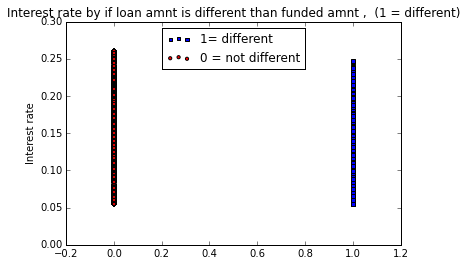

In [69]:
# Create a scatter plot to compare interest rate by if loan amnt is different than funded amnt or not
x1 = np.ones((len(df[(df['loan_amt'] != df['funded_amt'])]['int_rate']), 1))
y1 = df[(df['loan_amt'] != df['funded_amt'])]['int_rate']
x0 = np.zeros((len(df[(df['loan_amt'] == df['funded_amt'])]['int_rate']), 1))
y0 = df[(df['loan_amt'] == df['funded_amt'])]['int_rate']
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x1, y1, s=10, c='b', marker="s",label = '1= different')
ax1.scatter(x0,y0, s=10, c='r', marker="o",label = '0 = not different')
plt.ylabel("Interest rate")
plt.legend(loc='upper center');
plt.title("Interest rate by if loan amnt is different than funded amnt ,  (1 = different)")
plt.show()

3 There is not significant different of interest rate issued comparing the above two cases, thus we don't need to stratefied resampling using loan_amt and funded_amt these two predictors

### id_loan vs id_borrower
1. Let's look deeper into these two columns, first is to see if there were any typos like two different borrower share the same id_borrower or two different loans share the same id, if there are we may need to resolve any borrower or loan information conflict

In [76]:
print('there are %d unique id_loan' % len(pd.unique(df.id_loan.ravel())))
print('there are %d unique id_borrower' % len(pd.unique(df.id_borrower.ravel())))

there are 338989 unique id_loan
there are 338989 unique id_borrower


2 No duplicate id_loan or id_borrower, now we can remove these columns, since there were no conflicts to be resolved and these two columns have no predictive power

In [5]:
df.drop(['id_loan','id_borrower'],1, inplace=True)

Now we keep moving to next slice of columns

In [79]:
df.ix[:5,5:15]

,grade,subgrade,emp_title,emp_length,home_ownership,annal_inc,verification_status,issue_d,purpose,loan_cat
0,B,B4,NaN,< 1 year,RENT,85000,VERIFIED - income,Aug-09,Due to a lack of personal finance education an...,debt_consolidation
1,B,B5,CNN,< 1 year,RENT,65000,not verified,May-08,Just want to pay off the last bit of credit ca...,credit_card
2,D,D3,Web Programmer,1 year,RENT,70000,VERIFIED - income,Aug-14,Trying to pay a friend back for apartment brok...,debt_consolidation
3,C,C2,city of beaumont texas,10+ years,OWN,54000,not verified,Mar-10,"If funded, I would use this loan consolidate t...",debt_consolidation
4,C,C3,State Farm Insurance,6 years,RENT,32000,not verified,Nov-09,I currently have a personal loan with Citifina...,debt_consolidation
5,D,D4,Arkwright,9 years,RENT,58000,VERIFIED - income source,Aug-12,"Credit cards are out of here, I am tired of be...",debt_consolidation


### Examine the distribution of Grade and subgrade and their influence to interest rate
1. If the distribution of different grades and subgrades were not even, and the range of interest rate associated with different grades and subgrades are distince, we need to perform stratefied resampling to assure no grade or subgrade class were missing from the training data set 

In [85]:
print ("Grades count", df.grade.value_counts())
print ("\nSubgrades count",df.subgrade.value_counts())

Grades count B    86121
C    76446
D    46984
A    45525
E    21628
F     8395
G     2024
dtype: int64

Subgrades count B3    20352
B4    19137
B2    16767
C1    16342
C2    16310
B5    15521
C3    15425
C4    14646
B1    14344
C5    13723
A5    13086
A4    11806
D1    11720
D2    10498
D3     9091
D4     8573
A3     7653
D5     7102
A2     6496
A1     6484
E1     5447
E2     5246
E3     4230
E4     3640
E5     3065
F1     2490
F2     1873
F3     1712
F4     1331
F5      989
G1      677
G2      511
G3      378
G4      252
G5      206
dtype: int64


# To continue the above: scatter plot of interest rate by different grade, subgrade, distribution plot

### Employment title
emp_title is a free text field. Let's examine how many unique values exist:

In [92]:
print (df.emp_title.value_counts().head())
print (df.emp_title.value_counts().tail())
df.emp_title.unique().shape

Teacher             3602
Manager             2875
Registered Nurse    1537
RN                  1452
Supervisor          1286
dtype: int64
AMSTER ROTHSTEIN & EBENSTEIN LLP    1
EvaluMed                            1
c.t. tech aid                       1
Dr Jani Rollins MD                  1
Kintetsu World Express USA Inc.     1
dtype: int64


(163397,)

There were 163397 unique entries among 338989 observations.It shows some suspiciously specific titles such as EvaluMed/c.t. tech aid. This predictor won't be meaningful and any relationship we might observe might be due to confounding relationships with other predictors like income, employment length.

In [6]:
df.drop(['emp_title'],1, inplace=True)

### Employment length
emp_length may or may not be confounding with other predictors like income( a 2 year director may make more income than a 10 year tech aid), we can convert this column to int type and leave it for now, and we will examine further pair-wise correlation among predictors to determine if we remove it or not.

In [7]:
df.replace('n/a', np.nan,inplace=True)
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)

###Verification Status
VERIFIED - income and VERIFIED - income source could potentially be the same criteria.For now we'll trust that these are indeed different methods or levels (perhaps even ordinal) of verification.

In [95]:
df.verification_status.value_counts()

VERIFIED - income           127040
not verified                107873
VERIFIED - income source    104076
dtype: int64

###Purpose loan category and loan title
1. Loan purpose is self filled by borrower and we can use natural language processing technique to extract useful n-grams words and cluster them into different subgroups using unsupervised learning techniques, to keep this project not too sophisticated, for now we will drop this column 
2. Examing the loan category unique counts show they are state farm selected options.
3. Examing the loan title unique counts show they are free text fields and we can drop this column.

In [8]:
df.drop(['purpose'],1, inplace=True)
print('loan category unique counts:')
print (df.loan_cat.value_counts())
print('\nloan title unique counts:')
print (df.loan_title.value_counts())

loan category unique counts:
debt_consolidation    198226
credit_card            75680
home_improvement       19625
other                  17154
major_purchase          7312
small_business          5359
car                     4115
medical                 3329
moving                  2138
wedding                 1934
vacation                1848
house                   1723
educational              279
renewable_energy         267
dtype: int64

loan title unique counts:
Debt consolidation                          105698
Credit card refinancing                      40499
Debt Consolidation                           13275
Home improvement                              9888
Other                                         8188
Consolidation                                 4504
debt consolidation                            4075
Debt Consolidation Loan                       3247
Major purchase                                3010
Business                                      2397
Credit Card Con

In [9]:
df.drop(['loan_title'],1, inplace=True)

let's keep moving to the next slice of data

In [111]:
df.ix[:5,13:22]

,zip_code,state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line
0,941xx,CA,19.48,0,Feb-94,0,NaN,NaN,10
1,112xx,NY,14.29,0,Oct-00,0,NaN,NaN,7
2,100xx,NY,10.50,0,Jun-00,0,41,NaN,10
3,777xx,TX,5.47,0,Jan-85,0,64,NaN,5
4,067xx,CT,11.63,0,Dec-96,1,58,NaN,14
5,028xx,RI,2.05,0,Apr-94,0,26,NaN,6


In [10]:
df.drop(['zip_code'],1, inplace=True)

### Delinquency skewed distribution
Examine the distribution of delinquency, it shows it is a right skewed distribution and may need apply box-cox transformation in some cases before modelling depending on what model is used.

In [113]:
df.delinq_2yrs.value_counts()

0     280249
1      39796
2      11494
3       3964
4       1658
5        841
6        441
7        226
8        111
9         68
10        48
11        27
12        23
13        13
14         6
18         6
16         5
15         4
17         3
19         2
24         1
21         1
22         1
29         1
dtype: int64

### Earliest Credit Line type conversion
We will convert this column from object type to a scalar to describe the length of time since the first line of credit. 

In [23]:
from datetime import datetime
# Read the column in the correct format
t = pd.to_datetime(df['earliest_cr_line'],format = '%b-%y')

date_format = "%m/%d/%Y"
dttoday = datetime.strptime('1/1/2017', date_format)

d = np.zeros(len(t))
for i in range(len(t)):
    try:
        d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'D').astype(int))/-365)
        #break
    except:
        d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'M').astype(int))/-12)

d[d<0] = d[d<0] + 100

df['earliest_cr_line'] = d
# d[d<0]
# print(np.nonzero(d <0)[0][0])
# t[np.nonzero(d <0)[0][0]]

We move to the last slice of the predictors

In [52]:
df.ix[:5,21:]

,num_der_rec,revol_bal,revol_util,total_cr_line,init_list_status
0,0,28854,52.10%,42,f
1,0,33623,76.70%,7,f
2,0,19878,66.30%,17,f
3,0,2584,40.40%,31,f
4,0,3511,25.60%,40,f
5,0,3874,90.10%,25,f


### Revolving utility
Remove the % sign and convert it to float type

In [53]:
df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

In [35]:
# n_samples, n_features = 10, 5
# np.random.seed(0)
# y = np.random.randn(n_samples)
# X = np.random.randn(n_samples, n_features)
from sklearn import linear_model

clf = linear_model.SGDRegressor()
clf.fit(X, y)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [34]:
# Define X and Y vectors for model fitting
# flattern the vector column y into an 1-d array which is a required format for model fitting
y = np.ravel(df.ix[:, :1])
X = df.ix[:, 1:5]

In [ ]:
# Try random forest
#import randomforests as rf
# rf super slow, and interation 10 is not sufficient
# with error thrown out ome inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
#  warn("Some inputs do not have OOB scores. "
import sklearn.ensemble as sk
rfc = sk.RandomForestClassifier(n_estimators=100, oob_score=True)
model = rfc.fit(X, y)

In [36]:
## Try Support Vector Regression
# failed as there are a lot string type predictors in Y
clf = SVR(C=1.0, epsilon=0.2)
clf.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma=0.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [40]:
## Odinary Linear Regression
model = sm.OLS(y,X)
f = model.fit()

print ('Coefficients: ', f.params[0:2])
print ('Intercept: ', f.params[2])
print ('P-Values: ', f.pvalues)
print ('R-Squared: ', f.rsquared)

Coefficients:  X2   -1.140427e-08
X3    1.357400e-08
dtype: float64
Intercept:  6.255497628e-06
P-Values:  X2     0.000000e+00
X3     0.000000e+00
X4    5.828193e-142
X5     4.125758e-04
dtype: float64
R-Squared:  0.781409902785


In [41]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
## Gradient_boosting
from sklearn import ensemble

# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X, y)
#mse = mean_squared_error(y_test, clf.predict(X_test))
#print("MSE: %.4f" % mse)

# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [44]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html
# Decision tree regression with adaboost
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
rng = np.random.RandomState(1)
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)
regr_1.fit(X, y)
regr_2.fit(X, y)

#http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=<mtrand.RandomState object at 0x0000000010974EB8>)